# The Goal it to create a model to predict breast cancer. 
    What traits are most indicative?
    
    Possible Solutions: Random Forest, Logistic Regression, SVM, Gradient Boost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy

%matplotlib inline
# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [3]:
col_names = ['Sample ID', 'Clump Thickness', 'Unif of Cell Size', 'Unif of Cell Shape', 'Marginal Adhesion',
             'Single Epi Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Classes']
## Classes:
## 2 => Benign 
## 4 => Malignant 

df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                 names = col_names).dropna()

# Find the types of each column
df.dtypes

Sample ID                int64
Clump Thickness          int64
Unif of Cell Size        int64
Unif of Cell Shape       int64
Marginal Adhesion        int64
Single Epi Cell Size     int64
Bare Nuclei             object
Bland Chromatin          int64
Normal Nucleoli          int64
Mitoses                  int64
Classes                  int64
dtype: object

In [4]:
# Want to change the Classes to 0 and 1
## 0 => Benign
## 1 => Malignant
df['Classes'] = df['Classes'].apply(lambda x: 1 if x == 4 else 0)

# Want to change 'Bare Nuclei' to int type
## there is a '?' string, want to treat it as a null value and drop it
df.drop(df[df['Bare Nuclei'] == '?'].index, inplace = True)
df['Bare Nuclei'] = pd.to_numeric(df['Bare Nuclei']).astype(int)

# Drop Sample ID since it doesnt offer any information
df.drop(['Sample ID'], 1, inplace=True)

    try imputation since there is a little

In [5]:
df.head()

,Clump Thickness,Unif of Cell Size,Unif of Cell Shape,Marginal Adhesion,Single Epi Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Classes
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


In [6]:
df.shape

(683, 10)

# Try Gradient Boost

In [7]:
# Setting the target variable and the features
Y = df['Classes']     # target
X = df.loc[:, ~df.columns.isin(['Classes'])]

# Subsampling for training and testing data
train_set = int(X.shape[0] * 0.9)
test_set = int(X.shape[0] * 0.1)

# Randomly choose 90% of data for training set
X_train, Y_train = X.sample(train_set), Y.sample(train_set)

# Randomly choose 10% of data for test set
X_test, Y_test = X.sample(test_set), Y.sample(test_set)

In [8]:
from sklearn import ensemble

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 250,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, Y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

In [9]:
# Accuracy tables.
table_train = pd.crosstab(Y_train, predict_train, margins=True)
table_test = pd.crosstab(Y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

Training set accuracy:
Percent Type I errors: 0.013029315960912053
Percent Type II errors: 0.26547231270358307

Test set accuracy:
Percent Type I errors: 0.014705882352941176
Percent Type II errors: 0.2647058823529412


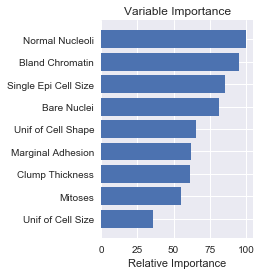

In [10]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

    Note: depending on the subsampling of the dataset, the variable importance changes

# Try Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lr = LogisticRegression(C = 1e9)

# Setting the target variable and the features
Y = df['Classes'] 
X = df.loc[:, ~df.columns.isin(['Classes'])]

# Fit the model.
fit = lr.fit(X, Y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)
Y_pred = lr.predict(X)

print('\n Accuracy of Cancer Diagnostics')
print(pd.crosstab(Y_pred, Y))

print('\n Percentage Accuracy')
print(lr.score(X, Y))

# Want to compare the mean squared error
print('\n Mean Squared Error')
print(mean_squared_error(Y, Y_pred))

Coefficients
[[ 0.53500128 -0.0062973   0.32272341  0.3306315   0.09663184  0.38302185
   0.44717376  0.21302828  0.53483577]]
[-10.10378265]

 Accuracy of Cancer Diagnostics
Classes    0    1
row_0            
0        434   11
1         10  228

 Percentage Accuracy
0.96925329429

 Mean Squared Error
0.0307467057101


   ### Try random permutation/shuffle
       want to avoid overlap between training and test set

In [14]:
# Declare a logistic regression classifier.
# Parameter regularization coefficient C described above.
lr = LogisticRegression(C = 1e9)

        ### Try random permutation/shuffle
    
# Subsampling for training and testing data
train_set = int(X.shape[0] * 0.9)
test_set = int(X.shape[0] * 0.1)

# Randomly choose 90% of data for training set
X_train, Y_train = X.sample(train_set), Y.sample(train_set)

# Randomly choose 10% of data for test set
X_test, Y_test = X.sample(test_set), Y.sample(test_set)

# Fit the model.
train_fit = lr.fit(X_train, Y_train)

# Display.
print('Coefficients')
print(train_fit.coef_)
print(train_fit.intercept_)
Y_train_pred = lr.predict(X_train)

print('\n Accuracy of Cancer Diagnostics')
print(pd.crosstab(Y_train_pred, Y_train))

# Want to compare the mean squared error
print('\n Mean Squared Error')
print(mean_squared_error(Y_train, Y_train_pred))

print('\n Percentage Accuracy for Training Set')
print(lr.score(X_train, Y_train))

print('\n Percentage Accuracy for Test Set')
print(lr.score(X_test, Y_test))

Coefficients
[[-0.05212775  0.02348921 -0.00111669 -0.06646707 -0.00446257 -0.0198197
   0.05340163  0.07030874  0.00025972]]
[-0.59581501]

 Accuracy of Cancer Diagnostics
Classes    0    1
row_0            
0        402  210
1          0    2

 Mean Squared Error
0.342019543974

 Percentage Accuracy for Training Set
0.657980456026

 Percentage Accuracy for Test Set
0.647058823529


    Note: It seems like after subsampling, the accuracy goes down tremendously.

    How to fix the error down below?

In [204]:
# List the coef next to their respecting features
dat = {'Columns': list(X),
       'Coef': coef}
list_df = pd.DataFrame(dat)
list_df

Exception: Data must be 1-dimensional